In [1]:
import os
import pandas as pd
from flask import jsonify
from flask import *
from sklearn.cluster import KMeans
from sklearn import manifold
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

Exception in thread _colab_inspector_thread:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy.py", line 64, in inspector_thread
    _variable_inspector.run(shell, time)
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py", line 27, in run
    globals().clear()
TypeError: 'module' object is not callable


In [7]:
df1 = pd.read_csv('/content/drive/MyDrive/mds/merged_pollution.csv')
ftrs = ['NO2', 'Ozone', 'SO2', 'CO']
df1 = df1[ftrs]
x = df1.values

In [12]:
k_inertia = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init='k-means++')
    kmeans.fit(x)
    k_inertia.append(kmeans.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

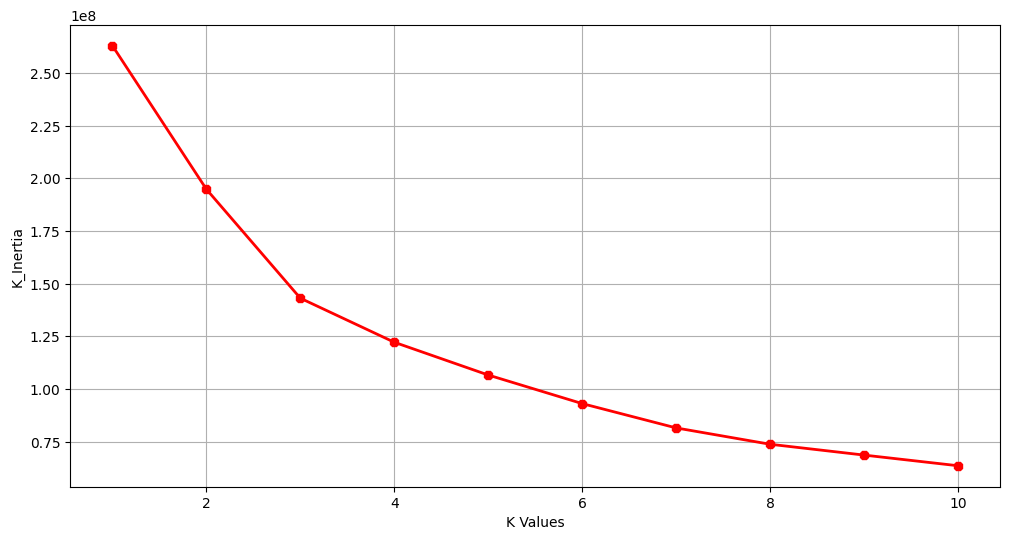

In [13]:
plt.figure(figsize=(12,6))

plt.grid()

plt.plot(range(1,11),k_inertia,linewidth = 2, color = "red", marker = "8")

plt.xlabel('K Values')

plt.ylabel("K_Inertia")

plt.show()

In [14]:
data_csv = pd.read_csv('/content/drive/MyDrive/mds/merged_pollution.csv', nrows = 1000)
ftrs = ['NO2', 'Ozone', 'SO2', 'CO']
data_csv = data_csv[ftrs]
data_csv = data_csv.dropna()
data_csv_original = data_csv
scaler = StandardScaler()
data_csv[ftrs] = scaler.fit_transform(data_csv[ftrs])
samplesize = 200
imp_ftrs = []
adaptive_samples = []

In [15]:
def clustering():
    features = data_csv[ftrs]
    k = 3
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(features)
    kmeans_centres = kmeans.cluster_centers_
    labels = kmeans.labels_
    data_csv['kcluster'] = pd.Series(labels)

In [16]:
def adaptive_sampling():
    global data_csv
    global adaptive_samples
    kcluster0 = data_csv_original[data_csv_original['kcluster'] == 0]
    kcluster1 = data_csv_original[data_csv_original['kcluster'] == 1]
    kcluster2 = data_csv_original[data_csv_original['kcluster'] == 2]
    size_kcluster0 = len(kcluster0) * samplesize / len(data_csv)
    size_kcluster1 = len(kcluster1) * samplesize / len(data_csv)
    size_kcluster2 = len(kcluster2) * samplesize / len(data_csv)
    sample_cluster0 = kcluster0.loc[random.sample(list(kcluster0.index), int(size_kcluster0))]
    sample_cluster1 = kcluster1.loc[random.sample(list(kcluster1.index), int(size_kcluster1))]
    sample_cluster2 = kcluster2.loc[random.sample(list(kcluster2.index), int(size_kcluster2))]
    adaptive_samples = pd.concat([sample_cluster0, sample_cluster1,sample_cluster2])

In [17]:
def get_mds_euclidean():
    global adaptive_samples
    clustering()
    adaptive_sampling()
    input_data = adaptive_samples[ftrs]
    mds_data = manifold.MDS(n_components=2, dissimilarity='precomputed')
    similarity = pairwise_distances(input_data, metric='euclidean')
    X = mds_data.fit_transform(similarity)
    data_columns = pd.DataFrame(X)

    # Add original feature columns
    for feature in ftrs:
        data_columns[feature] = data_csv_original[feature][:samplesize]

    data_columns['clusterid'] = np.nan
    x = 0
    for index, row in adaptive_samples.iterrows():
        data_columns['clusterid'][x] = row['kcluster']
        x = x + 1
    print("MDS:\n", data_columns)

    # Save DataFrame to CSV
    data_columns.to_csv('/content/drive/MyDrive/mds/mds_result.csv', index=False)

    return data_columns.to_json(orient='columns')


In [18]:
get_mds_euclidean()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


MDS:
             0         1       NO2     Ozone       SO2        CO  clusterid
0    0.186015 -1.471656 -1.172522 -0.881531 -0.209300 -1.284132        0.0
1    0.186015 -1.471656 -1.084125 -0.752737 -0.000561 -1.110767        0.0
2    0.186015 -1.471656 -0.889651 -0.840347 -0.005148 -1.284132        0.0
3    0.186015 -1.471656 -1.019836 -0.966895 -0.090020 -1.024085        0.0
4    0.186015 -1.471656 -1.101805 -0.957160  0.733468 -1.457497        0.0
..        ...       ...       ...       ...       ...       ...        ...
194 -0.096335 -0.064792  0.012001  0.692456 -0.317110 -0.070579        2.0
195  0.942999  1.695171  0.298086  0.455834  1.871212 -2.237639        2.0
196  2.165627  0.969567 -0.328731  1.533364  0.212767 -0.850720        2.0
197  1.213093 -0.346517 -0.232297  2.828047  0.836691 -0.850720        2.0
198  0.386603  0.886006 -0.020144  2.520288  0.559136 -0.850720        2.0

[199 rows x 7 columns]


'{"0":{"0":0.1860152401,"1":0.1860152401,"2":0.1860152401,"3":0.1860152401,"4":0.1860152401,"5":0.1860152401,"6":0.1860152401,"7":0.1860152401,"8":0.1860152401,"9":0.1860152401,"10":0.1860152401,"11":0.1860152401,"12":0.1860152401,"13":0.1860152401,"14":0.1860152401,"15":0.1860152401,"16":0.1860152401,"17":0.1860152401,"18":0.1860152401,"19":0.1860152401,"20":0.1860152401,"21":0.1860152401,"22":0.1860152401,"23":0.1860152401,"24":0.1860152401,"25":0.1860152401,"26":0.1860152401,"27":0.1860152401,"28":0.1860152401,"29":0.1860152401,"30":0.1860152401,"31":0.1860152401,"32":0.1860152401,"33":0.1860152401,"34":0.1860152401,"35":0.1860152401,"36":0.1860152401,"37":0.1860152401,"38":0.1860152401,"39":0.1860152401,"40":0.1860152401,"41":0.1860152401,"42":0.1860152401,"43":0.1860152401,"44":0.1860152401,"45":0.1860152401,"46":0.1860152401,"47":0.1860152401,"48":0.1860152401,"49":0.1860152401,"50":0.1860152401,"51":0.1860152401,"52":0.1860152401,"53":0.1860152401,"54":0.1860152401,"55":0.186015

In [20]:
def get_mds_correlation():
    global adaptive_samples
    clustering()
    adaptive_sampling()
    input_data = adaptive_samples[ftrs]
    mds_data = manifold.MDS(n_components=2, dissimilarity='precomputed')
    similarity = pairwise_distances(input_data, metric='correlation')
    X = mds_data.fit_transform(similarity)
    data_columns = pd.DataFrame(X)

    # Add original feature columns
    for feature in ftrs:
        data_columns[feature] = data_csv_original[feature][:samplesize]

    data_columns['clusterid'] = np.nan
    x = 0
    for index, row in adaptive_samples.iterrows():
        data_columns['clusterid'][x] = row['kcluster']
        x = x + 1
    print("MDS:\n", data_columns)

    # Save DataFrame to CSV
    data_columns.to_csv('/content/drive/MyDrive/mds/mds_result_correlation.csv', index=False)

    return data_columns.to_json(orient='columns')


In [21]:
get_mds_correlation()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


MDS:
             0         1       NO2     Ozone       SO2        CO  clusterid
0   -0.476450 -0.326552 -1.172522 -0.881531 -0.209300 -1.284132        0.0
1    0.832734  0.098678 -1.084125 -0.752737 -0.000561 -1.110767        0.0
2    0.590374  0.659816 -0.889651 -0.840347 -0.005148 -1.284132        0.0
3    0.164392  0.598972 -1.019836 -0.966895 -0.090020 -1.024085        0.0
4    0.748910  0.421589 -1.101805 -0.957160  0.733468 -1.457497        0.0
..        ...       ...       ...       ...       ...       ...        ...
194 -0.269802 -0.880733  0.012001  0.692456 -0.317110 -0.070579        2.0
195 -0.269802 -0.880733  0.298086  0.455834  1.871212 -2.237639        2.0
196 -0.269802 -0.880733 -0.328731  1.533364  0.212767 -0.850720        2.0
197 -0.269802 -0.880733 -0.232297  2.828047  0.836691 -0.850720        2.0
198 -0.269802 -0.880733 -0.020144  2.520288  0.559136 -0.850720        2.0

[199 rows x 7 columns]


'{"0":{"0":-0.4764499901,"1":0.832733575,"2":0.5903740471,"3":0.1643918255,"4":0.7489104484,"5":0.5289961556,"6":0.4449473689,"7":-0.4998710018,"8":-0.5477946012,"9":0.7504574697,"10":-0.7085116091,"11":0.2979772766,"12":0.0394258371,"13":0.0749348655,"14":-0.4799681314,"15":-0.0887868033,"16":0.1894472829,"17":0.8113538043,"18":0.4954458678,"19":0.8208807664,"20":-0.349217038,"21":0.727360025,"22":0.2795702676,"23":0.8145431739,"24":0.5949129365,"25":0.8413735857,"26":-0.7603498159,"27":-0.1474490613,"28":0.3897700833,"29":0.7047858799,"30":0.6053187938,"31":-0.653996874,"32":0.5105751604,"33":-0.4162848166,"34":-0.2202467458,"35":0.7147596291,"36":0.7895406205,"37":0.7896618238,"38":-0.7872719078,"39":-0.6617435552,"40":-0.7704057656,"41":0.8023417623,"42":-0.3391921385,"43":0.2787517872,"44":0.0396022182,"45":-0.1378259673,"46":-0.4223516092,"47":0.1967028335,"48":0.2874094057,"49":0.2412944134,"50":0.7834375846,"51":-0.3551849239,"52":-0.5331613377,"53":-0.556243252,"54":0.20095243